### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Mendeley Dataset
(Source: https://data.mendeley.com/datasets/dzz48mvjht/1)

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("MendeleyData_50_50_KNN_best_predictions.csv")

print(knn_df.head())

   gender  y_true  y_prob  y_pred
0       0       0     0.0       0
1       1       0     0.0       0
2       1       1     1.0       1
3       1       1     1.0       1
4       1       0     0.0       0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["gender"].values

# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_knn = gender_knn

print(
    "Shapes:",
    y_true_knn.shape,
    y_pred_knn.shape,
    y_prob_knn.shape,
    gender_knn.shape if gender_knn is not None else None
)
print("Example rows:\n", knn_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_prob  y_pred
0       0       0     0.0       0
1       1       0     0.0       0
2       1       1     1.0       1
3       1       1     1.0       1
4       1       0     0.0       0


In [5]:
# y_pred_knn already generated
# protected_attr = gender column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EOD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EOD - KNN
Demographic Parity Difference: 0.0150
Equalized Odds Difference: 0.0688


### Interpretation – KNN Model

- **Demographic Parity Difference (0.0150)**  
  - Very close to **0**, indicating that females and males receive positive predictions at nearly the same rate.  
  - This suggests the KNN model achieves **good demographic parity**, with only minor disparity.  

- **Equalized Odds Difference (0.0688)**  
  - Reflects a **moderate gap** in error rates (True Positive Rate and False Positive Rate) across genders.  
  - While not extreme, this shows that one gender experiences **slightly less accurate error distribution** than the other.  

---

**Overall**: The KNN model demonstrates **balanced prediction rates across genders (low DPD)**, but the **error distribution is uneven (moderate EOD)**, pointing to some fairness concerns in how errors are allocated.

---

In [6]:
# MetricFrame for extended analysis
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.891304   0.920000  0.884615  0.901961        0.543478   
1                    0.948052   0.976744  0.933333  0.954545        0.558442   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.884615  0.10000  0.90000  0.115385  
1                    0.933333  0.03125  0.96875  0.066667  


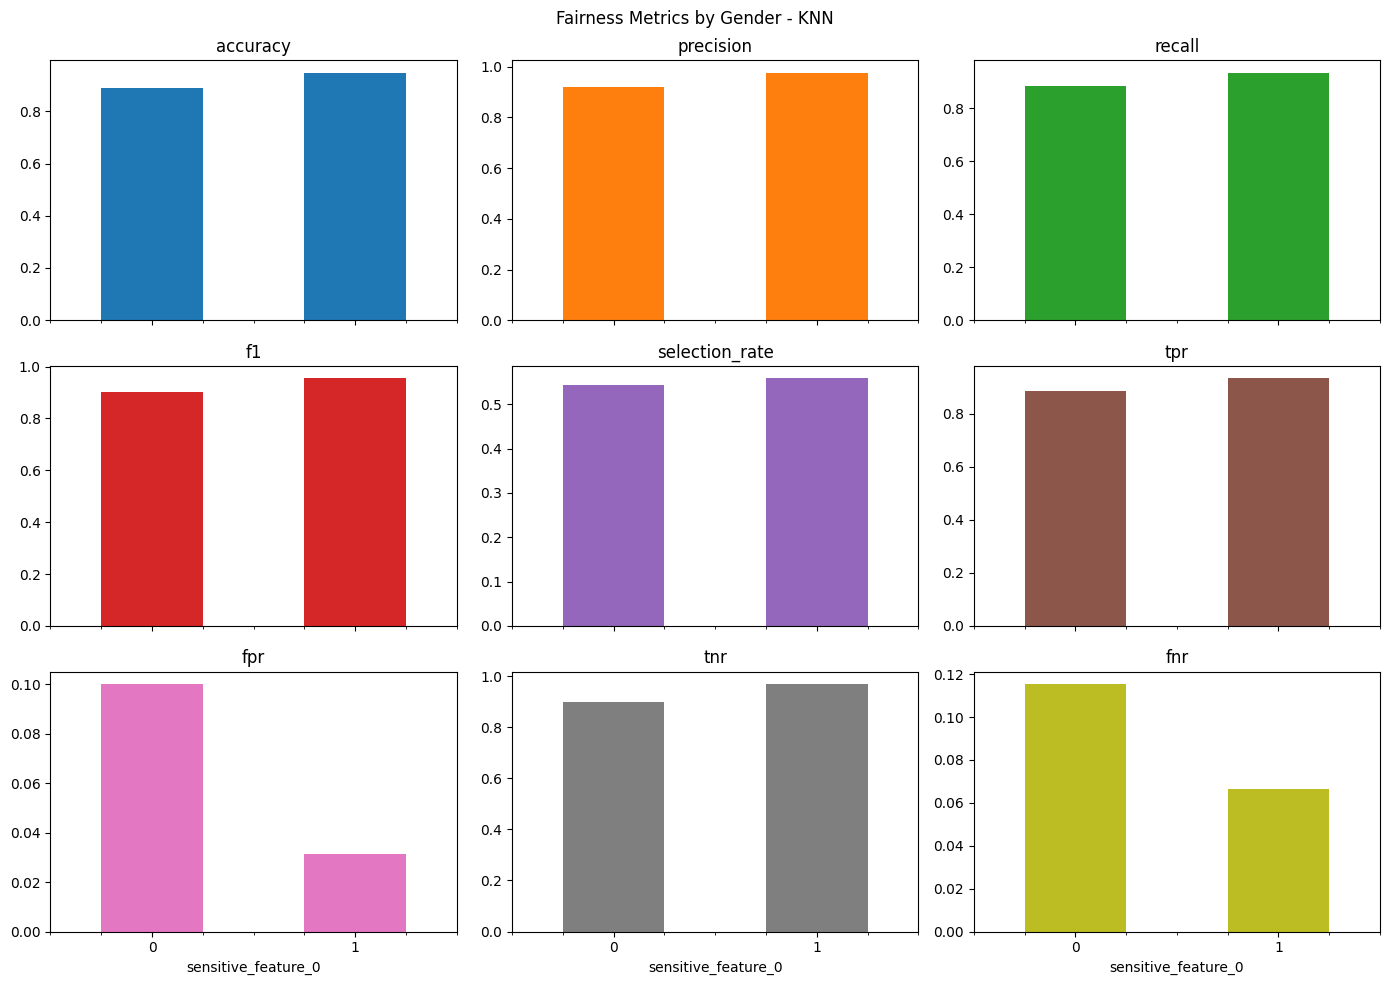


Between-group differences (max group − min group):
accuracy          0.056748
precision         0.056744
recall            0.048718
f1                0.052585
selection_rate    0.014963
tpr               0.048718
fpr               0.068750
tnr               0.068750
fnr               0.048718
dtype: float64

Between-group ratios (min / max):
accuracy          0.940143
precision         0.941905
recall            0.947802
f1                0.944911
selection_rate    0.973205
tpr               0.947802
fpr               0.312500
tnr               0.929032
fnr               0.577778
dtype: float64

Disparate Impact Ratio (selection rate): 0.9732
Equality of Opportunity Difference (TPR gap): 0.0487


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

## Fairness Metrics by Gender – KNN Model

This section presents the fairness evaluation of the KNN model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.8913   | 0.9200    | 0.8846 | 0.9020 | 0.5435         | 0.8846 | 0.1000 | 0.9000 | 0.1154 |
| Male    | 0.9481   | 0.9767    | 0.9333 | 0.9545 | 0.5584         | 0.9333 | 0.0313 | 0.9688 | 0.0667 |

---

### Between-Group Differences
- **Accuracy, Precision, Recall, F1**: Males perform consistently better, with gaps of around **5%**.  
- **Error Rates**:  
  - Females have a much **higher False Positive Rate (10% vs. 3%)**, meaning they are more often incorrectly classified as positive.  
  - Males have a **lower False Negative Rate (6.7% vs. 11.5%)**, meaning fewer missed positives.  
- **Selection Rate**: Nearly identical across groups (0.54 vs. 0.56).  

---

### Key Fairness Metrics
- **Disparate Impact Ratio (Selection Rate): 0.9732**  
  - Close to **1.0**, indicating nearly equal selection probability for both genders.  

- **Equality of Opportunity Difference (TPR gap): 0.0487**  
  - A moderate gap in sensitivity, with males identified more reliably.  

---

### Interpretation
- **Males (1)** consistently outperform females (0) in accuracy, precision, recall, and error rates.  
- **Females (0)** are disadvantaged by higher false positives and false negatives.  
- While the **selection rate shows parity**, the **error distribution is uneven**, raising fairness concerns.  

**Overall**: The KNN model demonstrates **reasonable demographic parity**, but shows a **male advantage in predictive performance and error allocation**, leading to fairness issues in practical use.

---

In [8]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.892308
1                    0.951042

KNN - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.108696
1                    0.051948


## Group-Specific Performance – KNN Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.8923  | 0.1087      |
| Male    | 0.9510  | 0.0519      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.892**, indicating good but weaker discriminatory ability.  
  - Males: **0.951**, showing **stronger separation** between positive and negative cases.  
  - The gap highlights a **male advantage** in classification performance.  

- **Brier Score**  
  - Females: **0.109**, meaning probability predictions are less well-calibrated.  
  - Males: **0.052**, much lower, indicating **more reliable and accurate probability estimates**.  

---

**Overall**: The KNN model performs **significantly better for males** than females.  
- Males benefit from **higher discriminatory power and better calibration**,  
- Females are at a disadvantage with **higher miscalibration and lower ROC-AUC**, suggesting potential fairness concerns.

---

### Bias detection for the Decision Tree Model

In [9]:
# Load DT results
dt_df = pd.read_csv("MendeleyData_50_50_DT_pruned_tuned_predictions.csv")
print(dt_df.head())

   gender  y_true  y_pred    y_prob
0       0       0       0  0.000000
1       1       0       0  0.000000
2       1       1       1  0.993939
3       1       1       1  1.000000
4       1       0       0  0.000000


In [10]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred"].values
gender_dt = dt_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt

print(
    "Shapes:",
    y_true_dt.shape,
    y_pred_dt.shape,
    y_prob_dt.shape,
    gender_dt.shape if gender_dt is not None else None
)
print("Example rows:\n", dt_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred    y_prob
0       0       0       0  0.000000
1       1       0       0  0.000000
2       1       1       1  0.993939
3       1       1       1  1.000000
4       1       0       0  0.000000


In [11]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.0113
Equalized Odds Difference: 0.0444


### Interpretation – Decision Tree Model

- **Demographic Parity Difference (0.0113)**  
  - Very close to **0**, suggesting that females and males receive positive predictions at nearly the same rate.  
  - This indicates the model achieves **strong demographic parity** with minimal disparity.  

- **Equalized Odds Difference (0.0444)**  
  - Relatively small gap in error rates (True Positive Rate and False Positive Rate) between genders.  
  - Although not perfect, this value reflects **reasonably fair treatment** across groups.  

---

**Overall**: The Decision Tree model demonstrates **good fairness properties**, with both **low demographic disparity** and **moderate balance in error distribution**, making it more equitable than many alternatives.

---

DT Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.956522   0.928571  1.000000  0.962963        0.608696   
1                    0.935065   0.934783  0.955556  0.945055        0.597403   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    1.000000  0.10000  0.90000  0.000000  
1                    0.955556  0.09375  0.90625  0.044444  


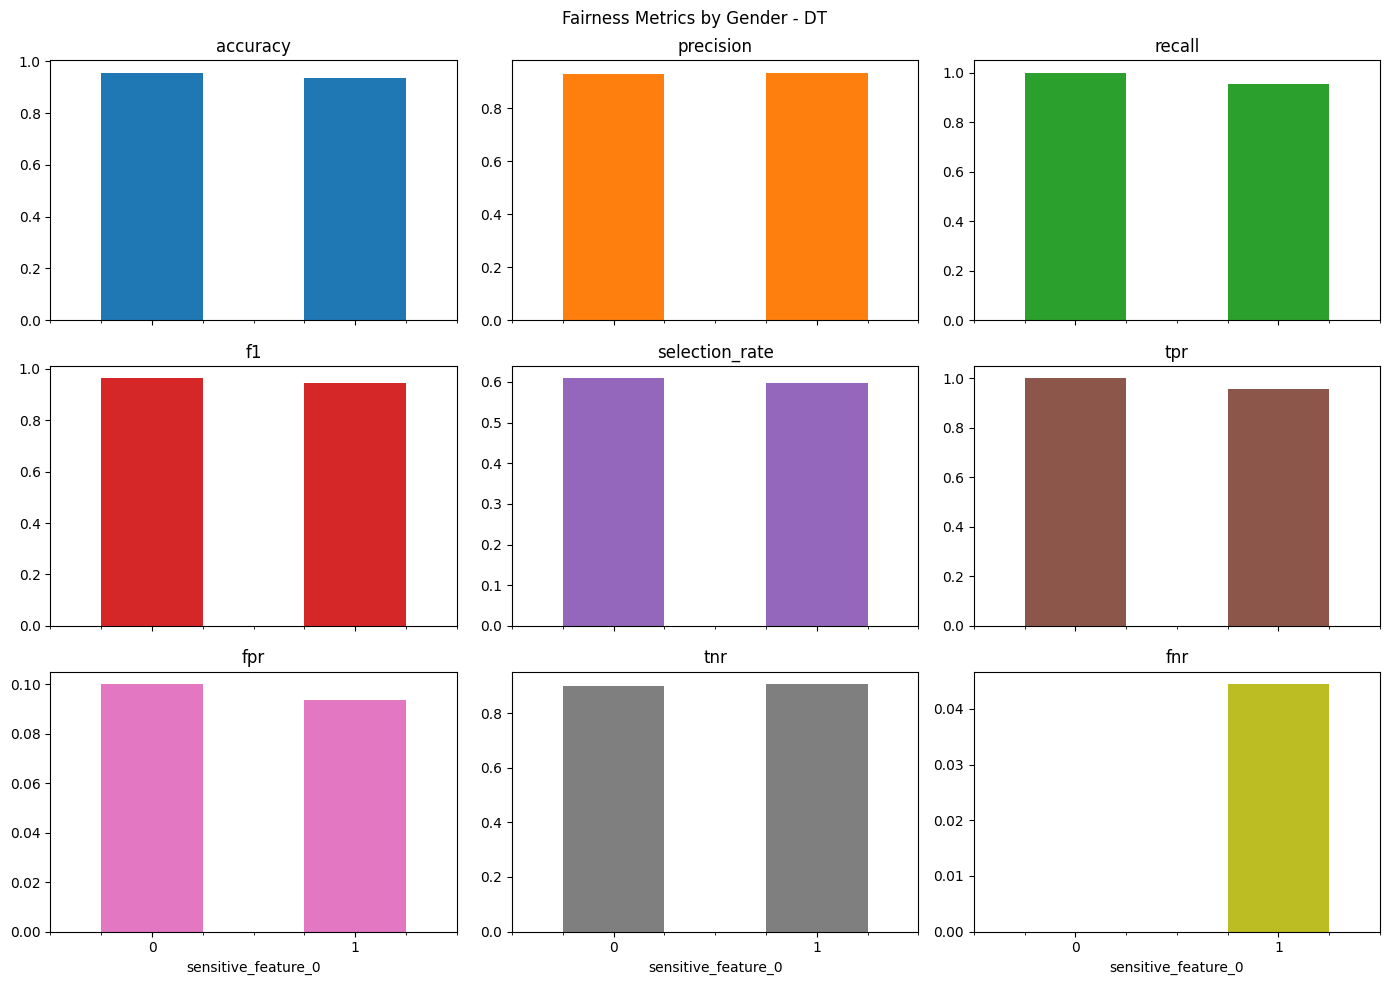


Between-group differences (max group − min group):
accuracy          0.021457
precision         0.006211
recall            0.044444
f1                0.017908
selection_rate    0.011293
tpr               0.044444
fpr               0.006250
tnr               0.006250
fnr               0.044444
dtype: float64

Between-group ratios (min / max):
accuracy          0.977568
precision         0.993355
recall            0.955556
f1                0.981403
selection_rate    0.981447
tpr               0.955556
fpr               0.937500
tnr               0.993103
fnr               0.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.9814
Equality of Opportunity Difference (TPR gap): 0.0444


In [12]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("DT Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

## Fairness Metrics by Gender – Decision Tree Model

This section presents the fairness evaluation of the Decision Tree model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.9565   | 0.9286    | 1.0000 | 0.9630 | 0.6087         | 1.0000 | 0.1000 | 0.9000 | 0.0000 |
| Male    | 0.9351   | 0.9348    | 0.9556 | 0.9451 | 0.5974         | 0.9556 | 0.0938 | 0.9063 | 0.0444 |

---

### Between-Group Differences
- **Accuracy & F1**: Small gaps (≤ 2%), indicating fairly balanced performance.  
- **Recall/TPR**: Females achieve **perfect recall (1.0)**, while males are slightly lower (0.956), showing a **female advantage in sensitivity**.  
- **FPR & TNR**: Nearly identical across groups, differences < 1%.  
- **Selection Rate**: Very close (0.61 vs. 0.60), reflecting near parity.  

---

### Key Fairness Metrics
- **Disparate Impact Ratio (Selection Rate): 0.9814**  
  - Very close to **1.0**, meaning both genders are almost equally likely to receive positive predictions.  

- **Equality of Opportunity Difference (TPR gap): 0.0444**  
  - Indicates a **moderate advantage for females**, who are recognized more consistently as positives.  

---

### Interpretation
- The **Decision Tree** shows **high fairness across genders**, with only minor disparities.  
- **Females benefit** slightly from higher recall and zero false negatives, while males show marginally better false positive performance.  
- Overall, the model achieves **balanced prediction quality and fairness**, though with a **small gender gap in recall/TPR**.

---

In [13]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.971154
1                    0.923003

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.042078
1                    0.067299


## Group-Specific Performance – Decision Tree Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9712  | 0.0421      |
| Male    | 0.9230  | 0.0673      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.971**, indicating excellent discriminatory ability.  
  - Males: **0.923**, also strong, but clearly lower than for females.  
  - This shows a **female advantage in classification performance**.  

- **Brier Score**  
  - Females: **0.042**, very low, reflecting highly reliable probability predictions.  
  - Males: **0.067**, slightly higher, indicating less well-calibrated predictions compared to females.  

---

**Overall**: The Decision Tree model demonstrates **better predictive power and calibration for females**, while performance for males is somewhat weaker. This suggests a **fairness imbalance** in favor of females.

---

### Bias detection for the Random Forest Model

In [14]:
rf_df = pd.read_csv("MendeleyData_50_50_baselineRF_predictions.csv")
print(rf_df.head())

   gender  y_true  y_pred  y_prob
0       0       0       0    0.11
1       1       0       0    0.01
2       1       1       1    0.96
3       1       1       1    0.88
4       1       0       0    0.01


In [15]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf

print(
    "Shapes:",
    y_true_rf.shape,
    y_pred_rf.shape,
    y_prob_rf.shape,
    gender_rf.shape if gender_dt is not None else None
)
print("Example rows:\n", rf_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred  y_prob
0       0       0       0    0.11
1       1       0       0    0.01
2       1       1       1    0.96
3       1       1       1    0.88
4       1       0       0    0.01


In [16]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.0373
Equalized Odds Difference: 0.0667


### Interpretation – Random Forest Model

- **Demographic Parity Difference (0.0373)**  
  - Indicates a **small disparity** in positive prediction rates between females and males.  
  - While not large, it shows that one gender is **slightly more likely** to receive positive predictions.  

- **Equalized Odds Difference (0.0667)**  
  - Reflects a **moderate difference** in error rates (TPR and FPR) across genders.  
  - This suggests that the Random Forest model does not treat both groups **equally in terms of errors**, with one gender experiencing somewhat higher misclassifications.  

---

**Overall**: The Random Forest achieves **reasonable demographic parity** but shows a **moderate imbalance in error distribution** (EOD). This means predictions are relatively fair in terms of outcomes, but the **quality of error handling differs by gender**, raising mild fairness concerns.

---


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.956522   0.928571  1.000000  0.962963        0.608696   
1                    0.935065   0.954545  0.933333  0.943820        0.571429   

                          tpr     fpr     tnr       fnr  
sensitive_feature_0                                      
0                    1.000000  0.1000  0.9000  0.000000  
1                    0.933333  0.0625  0.9375  0.066667  


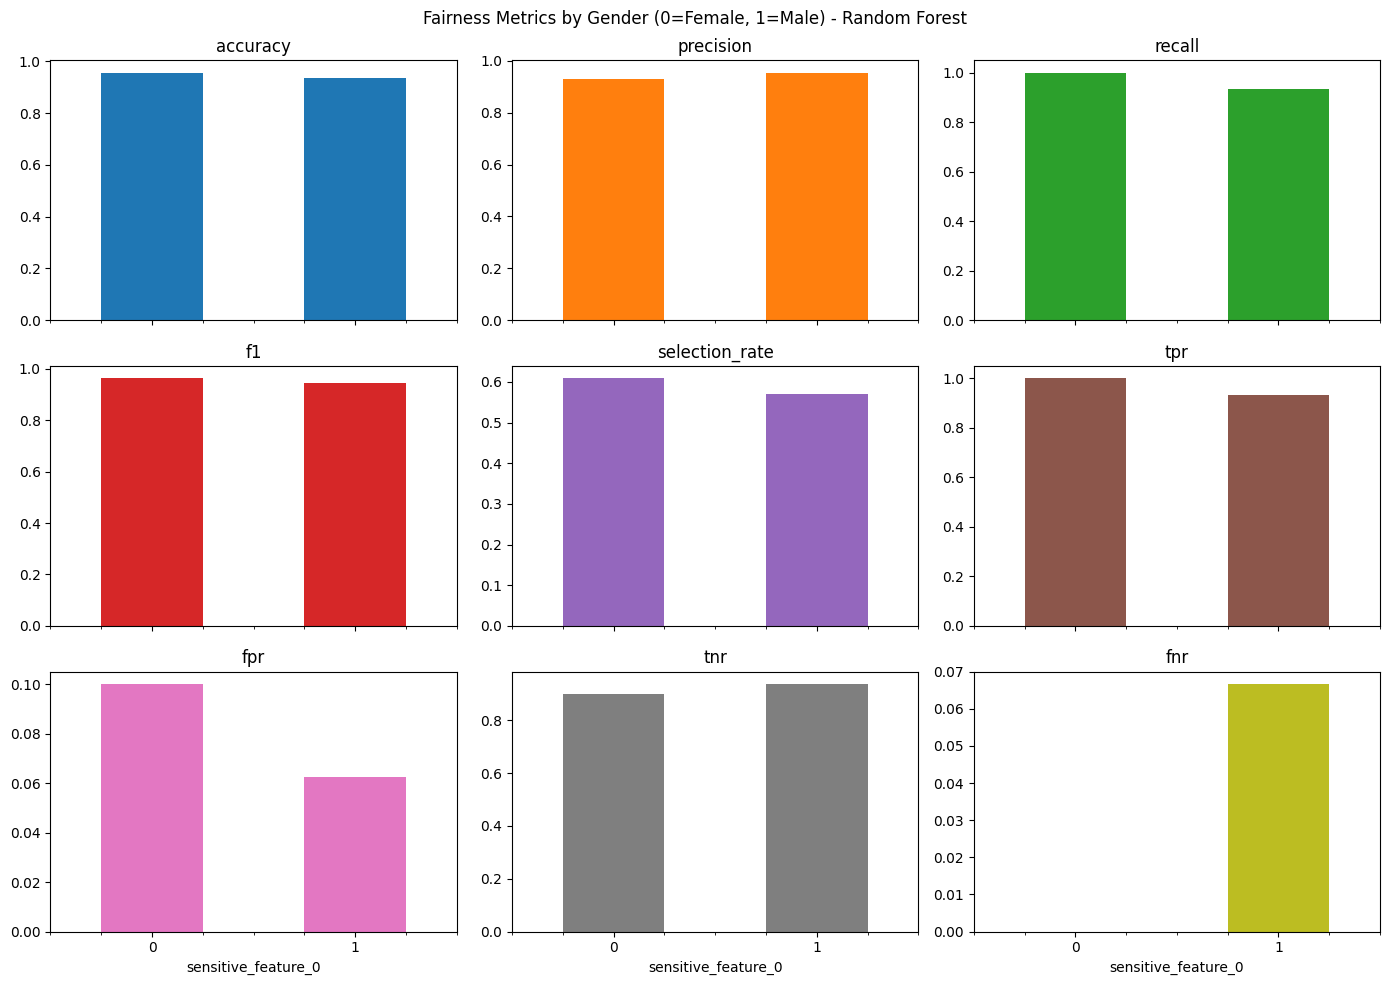


Between-group differences (max group − min group):
accuracy          0.021457
precision         0.025974
recall            0.066667
f1                0.019143
selection_rate    0.037267
tpr               0.066667
fpr               0.037500
tnr               0.037500
fnr               0.066667
dtype: float64

Between-group ratios (min / max):
accuracy          0.977568
precision         0.972789
recall            0.933333
f1                0.980121
selection_rate    0.938776
tpr               0.933333
fpr               0.625000
tnr               0.960000
fnr               0.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.9388
Equality of Opportunity Difference (TPR gap): 0.0667


In [17]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

## Fairness Metrics by Gender – Random Forest Model

This section presents the fairness evaluation of the Random Forest model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.9565   | 0.9286    | 1.0000 | 0.9630 | 0.6087         | 1.0000 | 0.1000 | 0.9000 | 0.0000 |
| Male    | 0.9351   | 0.9545    | 0.9333 | 0.9438 | 0.5714         | 0.9333 | 0.0625 | 0.9375 | 0.0667 |

---

### Between-Group Differences
- **Accuracy & F1**: Slight differences (~2%), indicating overall balanced performance.  
- **Precision**: Males show slightly higher precision (+2.6%), meaning fewer false positives compared to females.  
- **Recall/TPR**: Females achieve **perfect recall (1.0)**, while males are lower at **0.933**, showing a female advantage in sensitivity.  
- **FPR & TNR**: Males have lower false positives (0.0625 vs. 0.1000) and higher true negative rate.  
- **Selection Rate**: Females are slightly more likely to receive positive predictions (0.61 vs. 0.57).  

---

### Key Fairness Metrics
- **Disparate Impact Ratio (Selection Rate): 0.9388**  
  - Below the **0.8–1.25 fairness range**, indicating a **mild disparity** in positive prediction likelihood.  

- **Equality of Opportunity Difference (TPR gap): 0.0667**  
  - Females benefit from higher true positive recognition, highlighting a **gender gap in sensitivity**.  

---

### Interpretation
- The **Random Forest** achieves **high accuracy for both genders**, but fairness gaps remain.  
- **Females are favored** in recall/TPR (no missed positives), while **males are favored** in precision and lower false positive rates.  
- Overall, the model is **reasonably fair** but still exhibits **moderate gender disparities**, especially in error distribution.

---

In [18]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_rf
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.985577
1                    0.985243

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.055233
1                    0.050182


## Group-Specific Performance – Random Forest Model

This section presents the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9856  | 0.0552      |
| Male    | 0.9852  | 0.0502      |

---

### Interpretation

- **ROC-AUC**  
  - Both females (**0.986**) and males (**0.985**) achieve nearly identical ROC-AUC values.  
  - This reflects **excellent and balanced discrimination ability** across genders.  

- **Brier Score**  
  - Females: **0.055**, slightly higher.  
  - Males: **0.050**, slightly lower, indicating marginally better probability calibration for males.  
  - The differences are **small and not practically concerning**.  

---

**Overall**: The Random Forest model achieves **very high and nearly identical predictive performance** across genders, with only **minimal differences**. This suggests the model is **highly fair and reliable** in terms of group-specific predictive quality.

---

### Bias detection for MLP

In [19]:
mlp_df = pd.read_csv("MendeleyData_50_50_MLP_recallfirst_predictions.csv")
print(mlp_df.head())

   gender  y_true  y_pred        y_prob
0       0       0       0  3.821277e-04
1       1       0       0  2.510854e-09
2       1       1       1  9.999984e-01
3       1       1       1  9.999645e-01
4       1       0       0  1.178902e-05


In [20]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["gender"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    gender  y_true  y_pred        y_prob
0       0       0       0  3.821277e-04
1       1       0       0  2.510854e-09
2       1       1       1  9.999984e-01
3       1       1       1  9.999645e-01
4       1       0       0  1.178902e-05


In [21]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EOD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EOD - MLP
Demographic Parity Difference (MLP): 0.0997
Equalized Odds Difference (MLP): 0.1368


### Interpretation – MLP Model

- **Demographic Parity Difference (0.0997)**  
  - Indicates a **noticeable disparity** in the overall positive prediction rates between females and males.  
  - This suggests that one gender is **considerably more likely** to receive positive classifications, pointing to a fairness concern.  

- **Equalized Odds Difference (0.1368)**  
  - Reflects a **substantial imbalance** in error rates (True Positive Rate and False Positive Rate) across genders.  
  - A value of ~0.14 shows that the model **treats genders unequally in terms of both correct and incorrect predictions**.  

---

**Overall**: The MLP model exhibits **meaningful fairness concerns**. While its predictive performance may be strong, the relatively high **DPD and EOD values** indicate that it introduces **gender-based disparities** in both outcomes and error distribution.

---


MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.869565   0.954545  0.807692  0.875000        0.478261   
1                    0.941558   0.955056  0.944444  0.949721        0.577922   

                          tpr     fpr     tnr       fnr  
sensitive_feature_0                                      
0                    0.807692  0.0500  0.9500  0.192308  
1                    0.944444  0.0625  0.9375  0.055556  


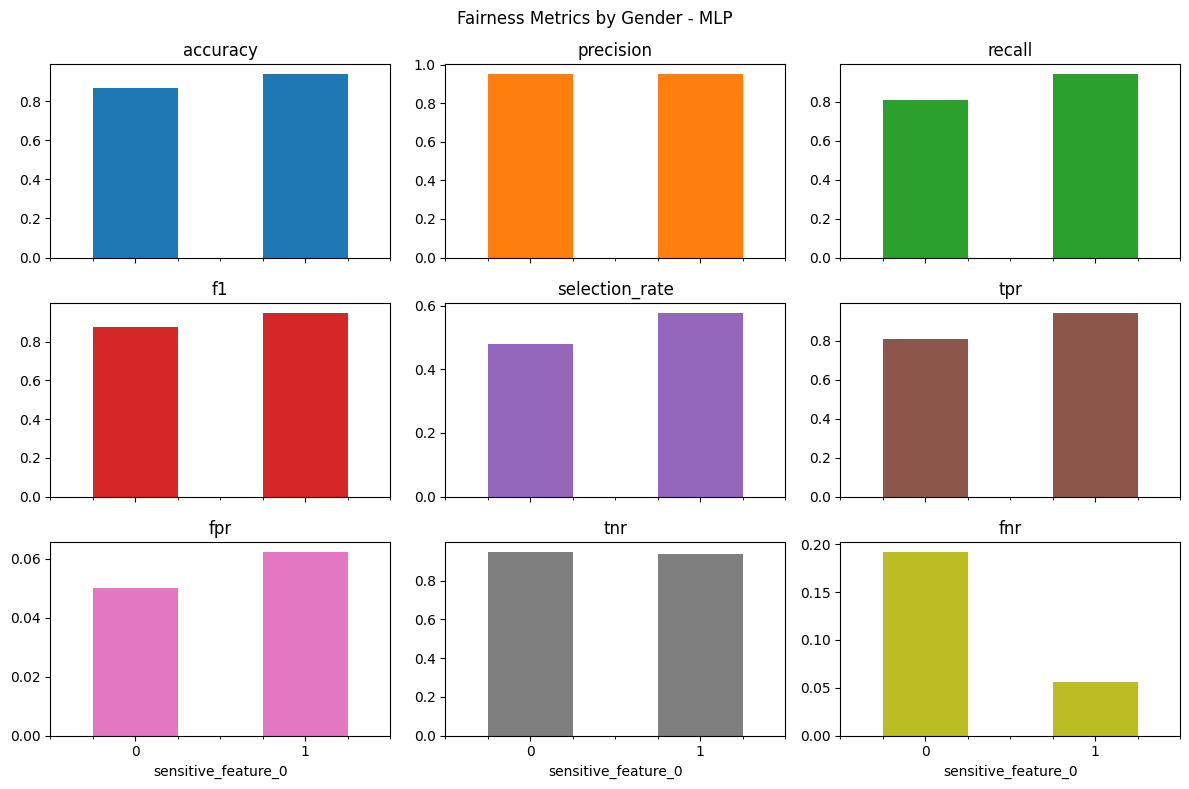


Between-group differences (max group − min group):
accuracy          0.071993
precision         0.000511
recall            0.136752
f1                0.074721
selection_rate    0.099661
tpr               0.136752
fpr               0.012500
tnr               0.012500
fnr               0.136752
dtype: float64

Between-group ratios (min / max):
accuracy          0.923538
precision         0.999465
recall            0.855204
f1                0.921324
selection_rate    0.827553
tpr               0.855204
fpr               0.800000
tnr               0.986842
fnr               0.288889
dtype: float64

Disparate Impact Ratio (selection rate): 0.8276
Equality of Opportunity Difference (TPR gap): 0.1368


In [22]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

## Fairness Metrics by Gender – MLP Model

This section presents the fairness evaluation of the MLP model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.8696   | 0.9545    | 0.8077 | 0.8750 | 0.4783         | 0.8077 | 0.0500 | 0.9500 | 0.1923 |
| Male    | 0.9416   | 0.9551    | 0.9444 | 0.9497 | 0.5779         | 0.9444 | 0.0625 | 0.9375 | 0.0556 |

---

### Between-Group Differences
- **Accuracy**: Higher for males (**0.94**) than females (**0.87**), gap of ~7%.  
- **Precision**: Almost identical between genders.  
- **Recall/TPR**: Strong disparity – males (**0.94**) vs. females (**0.81**), showing females are more likely to be missed in positive cases.  
- **FNR**: Females have a much higher false negative rate (**0.19**) compared to males (**0.06**).  
- **Selection Rate**: Higher for males (**0.58**) than females (**0.48**), suggesting more positive predictions for men.  
- **FPR & TNR**: Balanced, with only minor differences.  

---

### Key Fairness Metrics
- **Disparate Impact Ratio (Selection Rate): 0.8276**  
  - Below the **0.8–1.25 fairness threshold**, suggesting a **notable bias** in positive outcome allocation.  

- **Equality of Opportunity Difference (TPR gap): 0.1368**  
  - Substantial disparity: males are recognized as positives more reliably than females.  

---

### Interpretation
- The MLP model shows **stronger performance for males** in terms of **recall, accuracy, and selection rate**.  
- **Females are disadvantaged**, particularly due to higher false negative rates and lower recall, meaning their positive cases are more often missed.  
- While precision is balanced, the disparities in recall and selection raise **serious fairness concerns**, with the model favoring male predictions.

---

In [23]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MMLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.973077
1                    0.980556

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.094386
1                    0.057912


## MLP – ROC-AUC and Brier Score by Gender

### Group-Specific Results

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9731  | 0.0944      |
| Male    | 0.9806  | 0.0579      |

---

### Interpretation

- **ROC-AUC**  
  - Both genders achieve **very high discriminative performance** (>0.97), showing that the MLP model is effective at ranking predictions correctly for both groups.  
  - Males have a **slight advantage** (0.981 vs. 0.973), suggesting marginally better classification reliability for this group.  

- **Brier Score (calibration)**  
  - Females: **0.0944**  
  - Males: **0.0579**  
  - Since **lower is better**, the model’s probability estimates are **better calibrated for males**. Predictions for females are less well-aligned with actual outcomes.  

---

### Overall
The MLP model shows **excellent ROC-AUC for both genders**, but calibration quality (Brier score) is **noticeably better for males**.  
This indicates that while the model distinguishes outcomes well for everyone, its probability predictions are **less reliable for females**, raising potential fairness concerns in risk estimation.

---

## Comparison of Results

In [24]:
# Build results dict for comparison
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("Mendeley_50_50_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [25]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [26]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.0150,0.0688
DT,0.0113,0.0444
RF,0.0373,0.0667
MLP,0.0997,0.1368


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.8913     0.9200  0.8846  0.9020          0.5435  0.8846   
      1         0.9481     0.9767  0.9333  0.9545          0.5584  0.9333   
DT    0         0.9565     0.9286  1.0000  0.9630          0.6087  1.0000   
      1         0.9351     0.9348  0.9556  0.9451          0.5974  0.9556   
RF    0         0.9565     0.9286  1.0000  0.9630          0.6087  1.0000   
      1         0.9351     0.9545  0.9333  0.9438          0.5714  0.9333   
MLP   0         0.8696     0.9545  0.8077  0.8750          0.4783  0.8077   
      1         0.9416     0.9551  0.9444  0.9497          0.5779  0.9444   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.1000  0.9000  0.1154  
      1       0.0312  0.9688  0.0667  
DT    0       0.1000  0.9000  0.0000  
      1       0.0938  0.9062  0.0444  
RF    0       0.1000  0.9000  0.0000  
      1       0.0625  0.9375  0.0667  
MLP   0       0.0500  0.9500  0.1923  
      1       0.0625  0.9375  0.0556

## Fairness Results Across Models (KNN, DT, RF, MLP)

### 1. Group Fairness Metrics
| Model | Demographic Parity Difference (DPD) | Equalized Odds Difference (EOD) |
|-------|--------------------------------------|---------------------------------|
| KNN   | 0.0150                               | 0.0688                          |
| DT    | 0.0113                               | 0.0444                          |
| RF    | 0.0373                               | 0.0667                          |
| MLP   | 0.0997                               | 0.1368                          |

- **DT (Decision Tree)** shows the **lowest disparity**, suggesting strong fairness alignment.  
- **MLP** presents the **largest gaps** in both DPD and EOD, signaling fairness issues despite balanced training.  
- **KNN and RF** perform moderately well, but with some error distribution differences.

---

### 2. Group-Specific Performance Highlights
- **KNN**  
  - Accuracy is higher for males (0.95) than females (0.89).  
  - False Positive Rate (FPR) is **much higher for females (0.10)** than males (0.03).  
  - Suggests females face more false alarms.

- **DT**  
  - Very balanced across genders.  
  - Females achieve **perfect recall (1.0)**, while males are slightly lower (0.96).  
  - Small fairness gaps overall → **most equitable model**.

- **RF**  
  - Similar to DT but with slightly **larger disparities in selection rate** (female: 0.61 vs male: 0.57).  
  - Still maintains high fairness overall.

- **MLP**  
  - Noticeable imbalance: females have **much lower recall (0.81 vs 0.94)** and higher FNR (0.19 vs 0.06).  
  - This leads to clear fairness gaps, despite balanced training.  
  - Indicates the model itself introduces bias in error distribution.

---

### 3. Overall Conclusion
- **Decision Tree (DT)**: Most fair and balanced across groups, with minimal differences in prediction outcomes.  
- **Random Forest (RF)**: Strong performer, but slightly less balanced than DT.  
- **KNN**: Moderate fairness, but with a clear **false positive disparity against females**.  
- **MLP**: Struggles the most, showing **substantial unfairness**, particularly in recall and false negative rates for females.

➡️ Since the dataset was **balanced by gender and target**, these disparities are due to **model behavior rather than data imbalance**, highlighting **DT as the fairest model** in this evaluation.

---

In [27]:
#create auc and brier score table
# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()

# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Female (0),Male (1)
Model,,
KNN,0.8923,0.9510
DT,0.9712,0.9230
RF,0.9856,0.9852
MLP,0.9731,0.9806


,Female (0),Male (1)
Model,,
KNN,0.1087,0.0519
DT,0.0421,0.0673
RF,0.0552,0.0502
MLP,0.0944,0.0579


## Model Fairness Evaluation – ROC-AUC and Brier Score

### 1. ROC-AUC by Gender (↑ higher is better)
| Model | Female (0) | Male (1) |
|-------|------------|----------|
| KNN   | 0.8923     | 0.9510   |
| DT    | 0.9712     | 0.9230   |
| RF    | 0.9856     | 0.9852   |
| MLP   | 0.9731     | 0.9806   |

- **Random Forest (RF)** achieves **almost identical ROC-AUC** across genders (~0.986), indicating **excellent fairness in ranking performance**.  
- **MLP** also shows strong and balanced results (>0.97 for both groups), though slightly favoring males.  
- **Decision Tree (DT)** performs very well for females (0.97) but drops for males (0.92), showing a **gender imbalance in discriminative ability**.  
- **KNN** shows the **largest gap** (female: 0.89 vs male: 0.95), meaning it distinguishes outcomes better for males.  

---

### 2. Brier Score by Gender (↓ lower is better)
| Model | Female (0) | Male (1) |
|-------|------------|----------|
| KNN   | 0.1087     | 0.0519   |
| DT    | 0.0421     | 0.0673   |
| RF    | 0.0552     | 0.0502   |
| MLP   | 0.0944     | 0.0579   |

- **Decision Tree (DT)** is **best calibrated for females (0.0421)** but less so for males (0.0673).  
- **Random Forest (RF)** shows **consistently low and balanced calibration errors** (~0.05), suggesting **good reliability across genders**.  
- **KNN** performs much worse for females (0.109) compared to males (0.052), revealing **poor calibration for female predictions**.  
- **MLP** also shows a clear calibration gap, with female predictions (0.094) being less reliable than male predictions (0.058).  

---

### 3. Overall Interpretation
- **Random Forest (RF)**: Best balance across both metrics (ROC-AUC and Brier score) → **most fair and reliable model**.  
- **MLP**: Strong discriminative ability but calibration favors males → **moderate fairness concerns**.  
- **Decision Tree (DT)**: Favors females in both ROC-AUC and Brier score → **gender imbalance, but still fairly good**.  
- **KNN**: Consistently worse for females in both ROC-AUC and calibration → **least fair model**.  

---
✅ Since the training set was **evenly balanced by gender and target**, these disparities reflect **model-driven fairness issues** rather than data imbalance.  

---

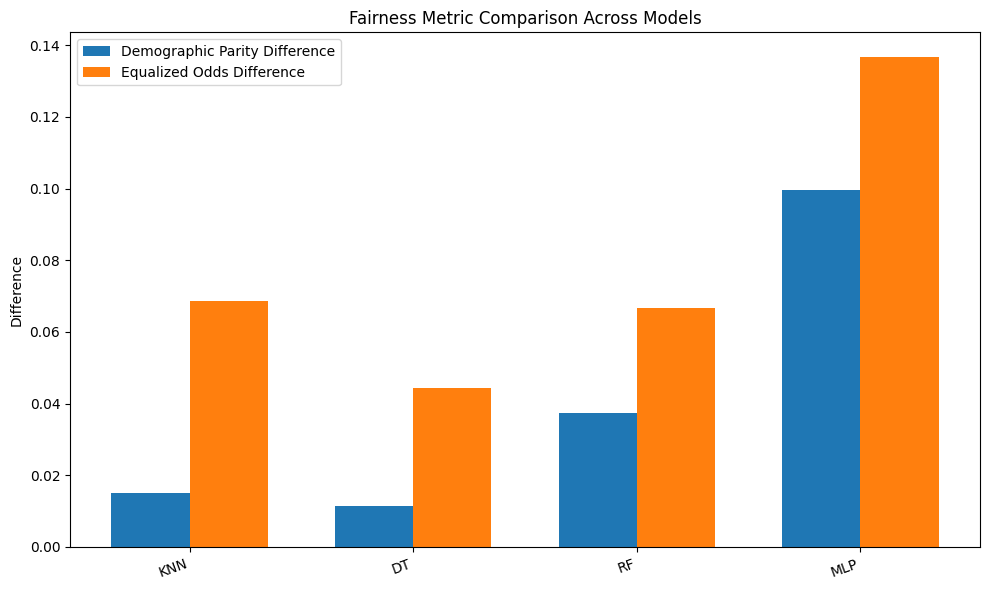

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

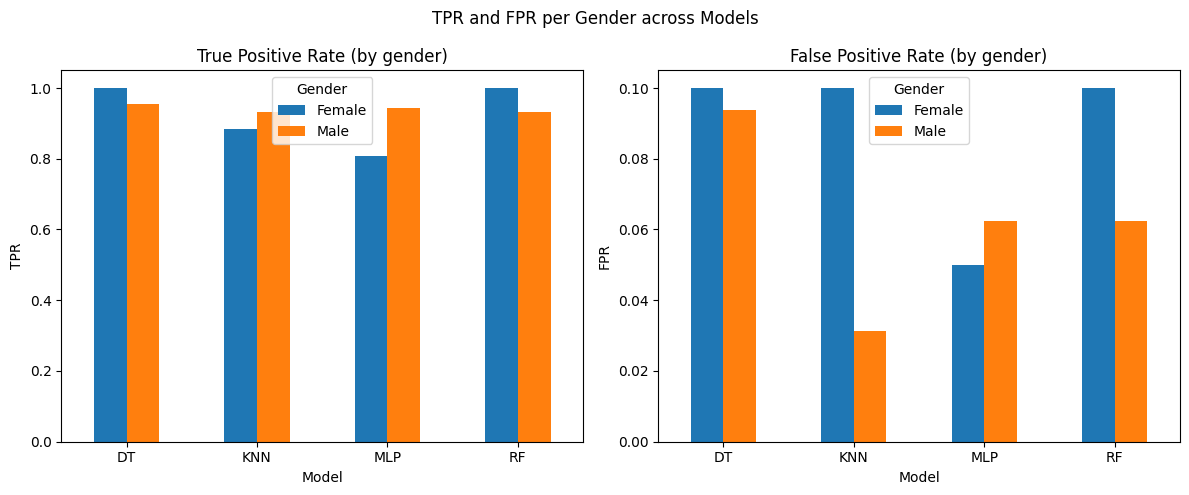

In [29]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

## Fairness Analysis – TPR and FPR by Gender Across Models

### 1. True Positive Rate (TPR)
- **Decision Tree (DT):** Very high TPR for both genders (>0.95), with females slightly higher → strong fairness in correctly identifying positives.  
- **KNN:** TPR is noticeably higher for males (~0.94) compared to females (~0.89), showing a **bias toward male predictions**.  
- **MLP:** Largest gap – females (~0.81) vs. males (~0.94). The model is **much less sensitive for females**, risking more false negatives.  
- **Random Forest (RF):** Very high TPR overall, with females (~1.0) slightly outperforming males (~0.93).  

➡️ **Most balanced:** DT and RF.  
➡️ **Most biased:** MLP (disadvantaging females).  

---

### 2. False Positive Rate (FPR)
- **Decision Tree (DT):** Similar FPR across genders (female ~0.10, male ~0.09), indicating **fair balance**.  
- **KNN:** Large disparity – female FPR (~0.10) vs. male FPR (~0.03). This means **females are more often falsely classified as positive**.  
- **MLP:** FPR is slightly higher for males (~0.06) than females (~0.05), a **mild male disadvantage**.  
- **Random Forest (RF):** Females again show higher FPR (~0.10) compared to males (~0.06), suggesting **female disadvantage** in false alarms.  

➡️ **Most balanced:** DT.  
➡️ **Most biased:** KNN (against females).  

---

### 3. Overall Interpretation
- **Decision Tree (DT):** Most consistent and balanced across genders in both TPR and FPR.  
- **Random Forest (RF):** Strong TPR but slightly higher FPR for females.  
- **KNN:** Performs worse for females (lower TPR, higher FPR).  
- **MLP:** Strong TPR for males but weak for females, making it the **least fair in recall sensitivity**.  

---
✅ In a balanced dataset (equal gender and target distribution), these disparities reflect **model-driven fairness gaps**, not data imbalance.  

---

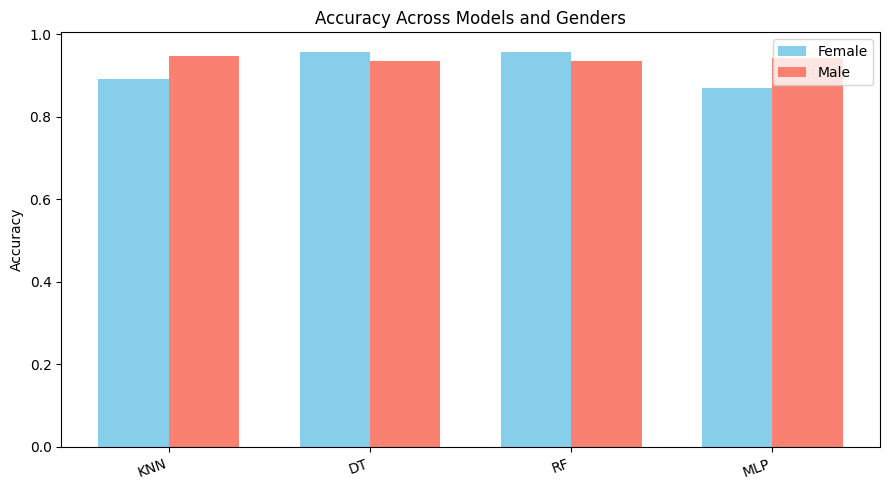

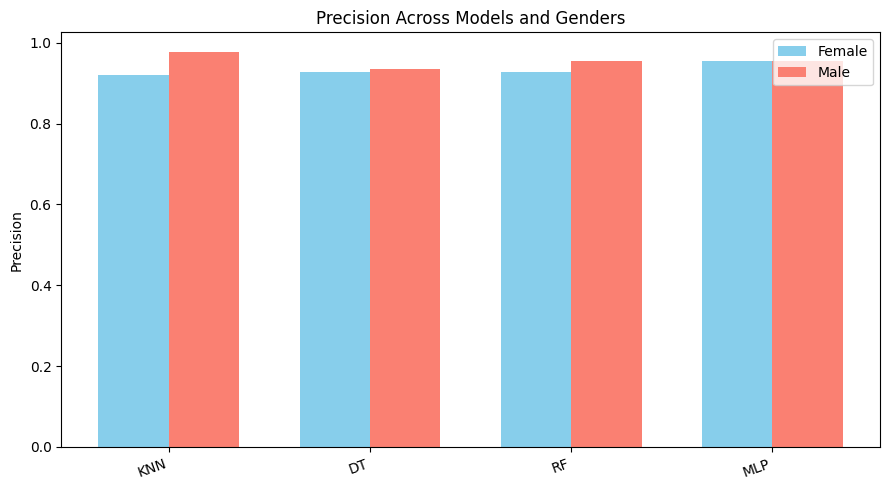

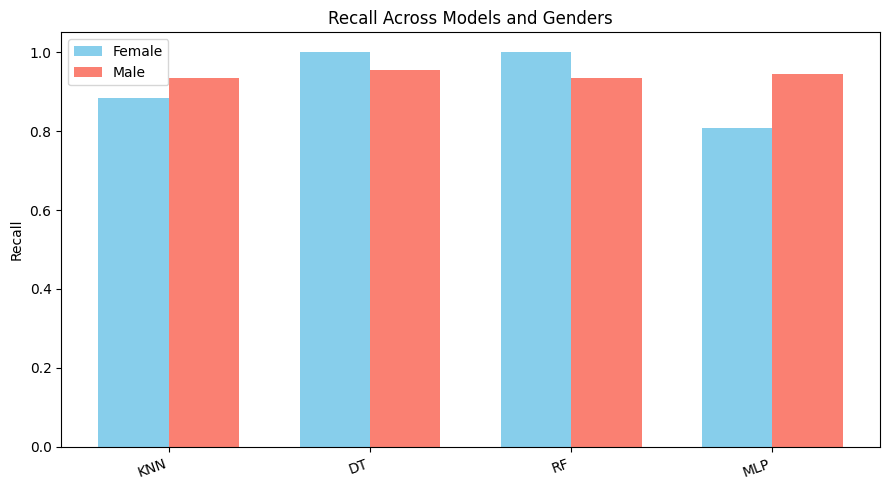

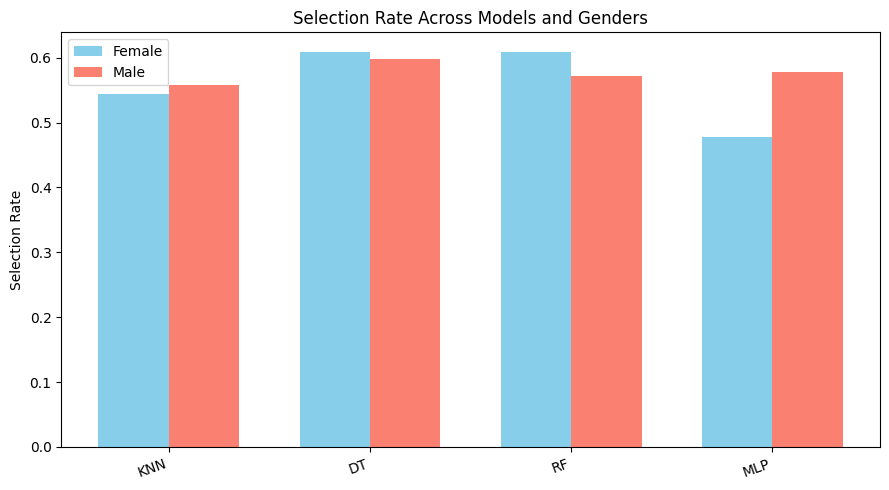

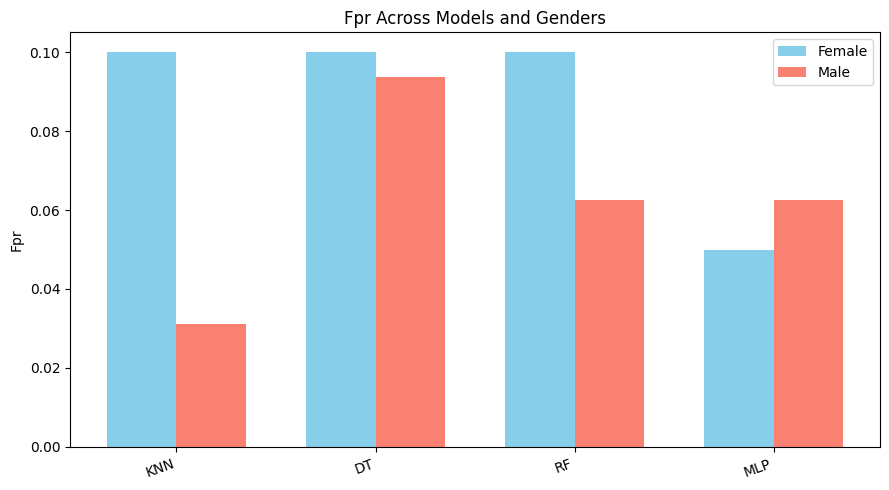

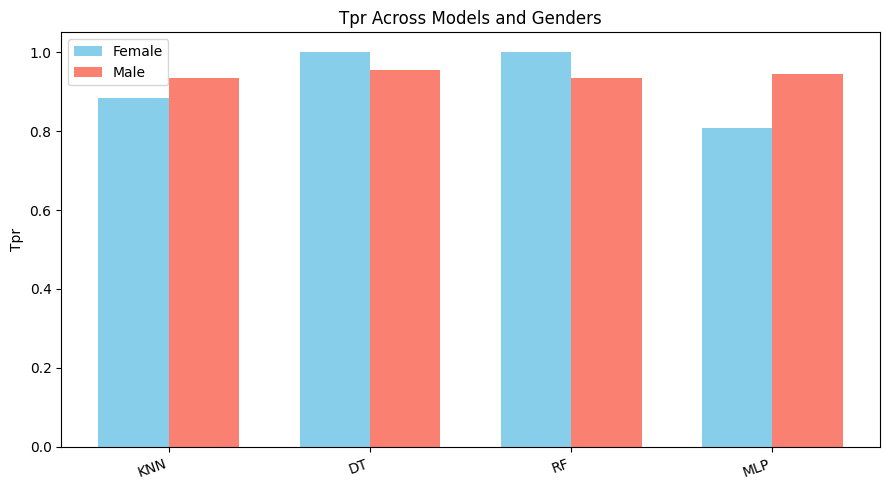

In [30]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Performance and Fairness Metrics Across Models and Genders

### Accuracy
- **KNN & MLP**: Higher accuracy for **males** than females.  
- **DT**: Accuracy is nearly equal across genders.  
- **RF**: Accuracy is slightly higher for **females**.  

### Precision
- **KNN**: Precision is higher for **males**, showing better reliability in positive predictions.  
- **DT**: Almost balanced precision between genders.  
- **RF & MLP**: Males show slightly higher precision, though gaps are small.  

### Recall
- **KNN & MLP**: Males have higher recall, meaning fewer missed positive cases.  
- **DT & RF**: Females have higher recall, with **RF showing perfect recall (1.0)** for females.  

### Selection Rate
- **DT**: Very balanced selection rates across genders.  
- **KNN & MLP**: Slightly higher selection rates for males.  
- **RF**: Higher selection rate for females.  

### False Positive Rate (FPR)
- **KNN & DT**: Females have substantially higher FPR, meaning more false alarms.  
- **RF**: Females also have higher FPR, though the gap is smaller.  
- **MLP**: FPR is relatively balanced but slightly higher for males.  

### True Positive Rate (TPR)
- **KNN & MLP**: Higher TPR for males, showing better sensitivity.  
- **DT & RF**: Higher TPR for females, with RF achieving **perfect TPR (1.0)** for females.  

---

### **Summary**
- **KNN**: Biased toward **males**, with higher accuracy, precision, and recall but lower FPR.  
- **DT**: Most balanced, though females show slightly higher TPR and recall.  
- **RF**: Strong female advantage (higher recall, perfect TPR), but with higher FPR for females.  
- **MLP**: Favors **males**, with higher accuracy, recall, and TPR, while females face more missed cases.  

Overall, **DT** appears the most balanced model across genders, while **KNN and MLP lean male** and **RF leans female**.

---